In [23]:
#Parte 3 histogramas y kernels 

In [1]:
import pandas as pd

In [5]:
import os

In [11]:
os.chdir("C:/Udesa/Big Data/TP2")

In [13]:
df = pd.read_excel("df_dummies_final_limpio.xlsx")

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
#1)

In [17]:
df_activos = df[(df['ESTADO'] == 1) & (df['ITF'] > 0)]
df_activos = df_activos[df_activos['ITF'] < df_activos['ITF'].quantile(0.99)]

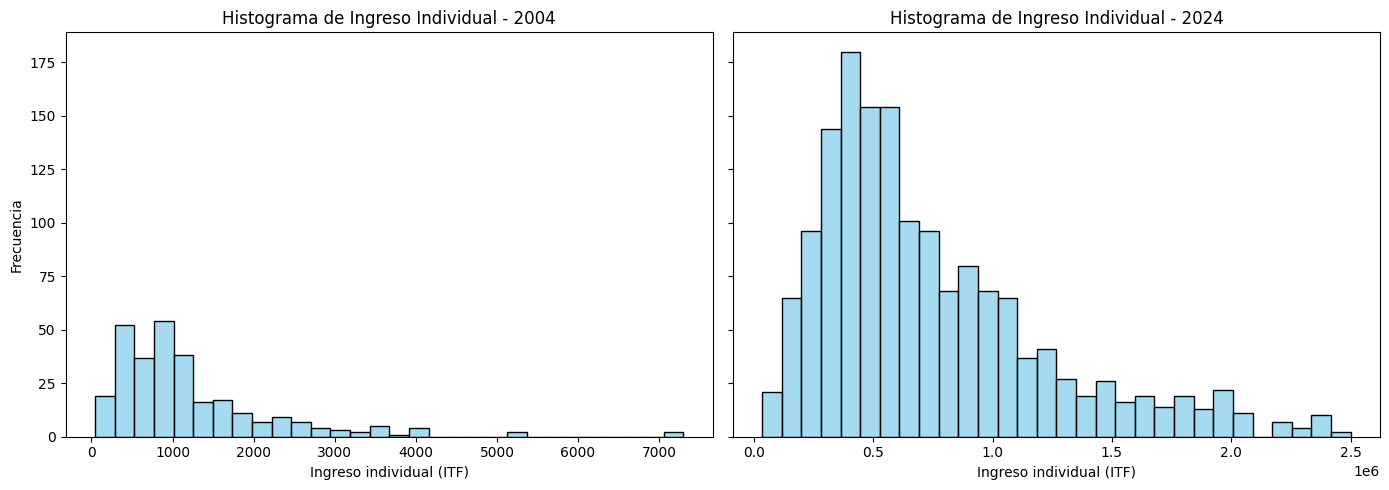

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
for i, year in enumerate([2004, 2024]):
    sns.histplot(
        df_activos[df_activos['ANO4'] == year]['ITF'],
        bins=30,
        kde=False,
        ax=axes[i],
        color='skyblue'
    )
    axes[i].set_title(f"Histograma de Ingreso Individual - {year}")
    axes[i].set_xlabel("Ingreso individual (ITF)")
    axes[i].set_ylabel("Frecuencia")
plt.tight_layout()
plt.show()

In [21]:
#Utilizamos una cantidad de bins estandar de 30. Tratamos los outliers excluyendo el 1% mas alto de los ingresos. En ambos histogramas se ve en primer lugar el efecto de la inflacion. Luego en 2024 hay mayor dispersion de los ingresos a comparacion del 2004. La mediana de los ingresos de 2004 es de 900 pesos aproximadamente mientras que en 2024 es de 600.000.  

In [29]:
#2a)

In [31]:
# Variable que nos dice si hay algún desocupado en el hogar
df['desocupado'] = df['ESTADO'].isin([2]).astype(int)

In [37]:
#b)
# Ingreso por hogar: solo miembros ocupados que reporten un ingreso positivo
df_ocupados = df[(df['ESTADO'] == 1) & (df['ITF'] > 0)]
ingreso_xhogar = df_ocupados.groupby(['CODUSU', 'ANO4'])['ITF'].sum().reset_index()
ingreso_xhogar.columns = ['CODUSU', 'ANO4', 'ingreso_xhogar']


In [39]:
# Variable hogar con desocupado
desocupado_xhogar = df.groupby(['CODUSU', 'ANO4'])['desocupado'].max().reset_index()

# Merge
hogares = pd.merge(ingreso_xhogar, desocupado_xhogar, on=['CODUSU', 'ANO4'])

In [51]:
#c)
# Filtrar hogares con ingreso > 0 y sin outliers extremos
hogares_filtrados = hogares[hogares['ingreso_xhogar'] > 0]
hogares_filtrados = hogares_filtrados[hogares_filtrados['ingreso_xhogar'] < hogares_filtrados['ingreso_xhogar'].quantile(0.99)]

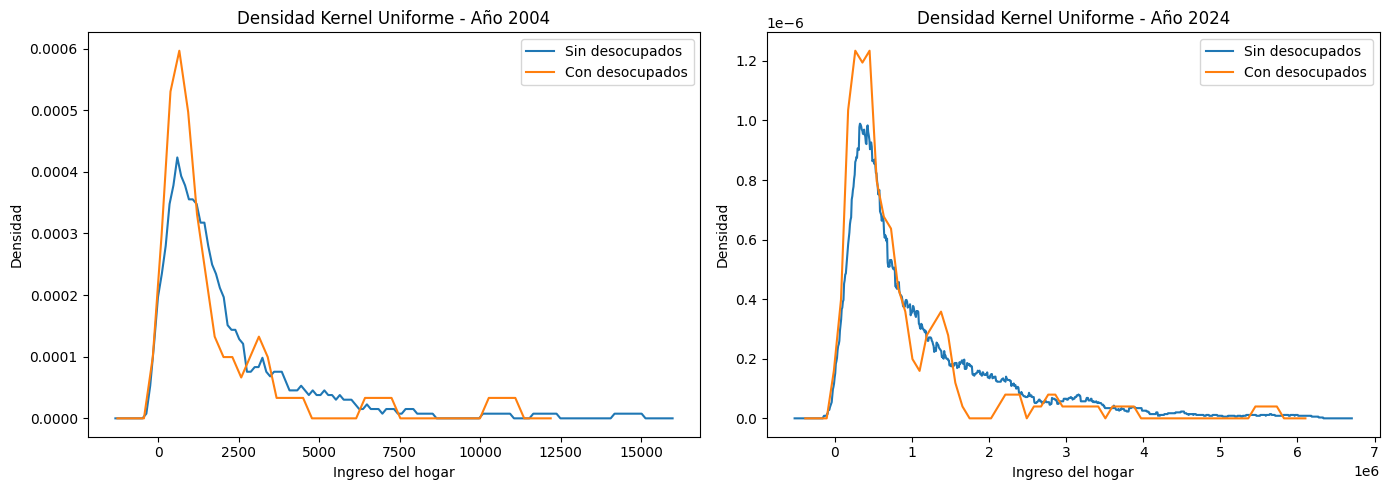

In [63]:
from statsmodels.nonparametric.kde import KDEUnivariate
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, year in enumerate([2004, 2024]):
    for d in [0, 1]:
        data = hogares_filtrados[
            (hogares_filtrados['ANO4'] == year) & 
            (hogares_filtrados['desocupado'] == d)
        ]['ingreso_xhogar']  # asegurate que esta sea la columna correcta

        kde = KDEUnivariate(data)
        kde.fit(kernel='uni', bw='silverman', fft=False) 
        label = "Con desocupados" if d == 1 else "Sin desocupados"
        axes[i].plot(kde.support, kde.density, label=label)

    axes[i].set_title(f"Densidad Kernel Uniforme - Año {year}")
    axes[i].set_xlabel("Ingreso del hogar")
    axes[i].set_ylabel("Densidad")
    axes[i].legend()

plt.tight_layout()
plt.show()

In [65]:
#d) Mira abuela, viste que vos utilizas unos audifonos. Esos audifonos vos los podes regular,generalmente cuando salimos a comer. El efecto de un ancho de banda alto es el mismo que cuando vos aumentas lo que puden escuchar tus audifonos, terminas escuchando conversaciones de las mesas de al lado y no te enfocas en lo que estan hablando tus nietos, no te terminas enterando de lo que estamos hablando por que te distraes con las otrasconversaciones. En sentido opuesto, cuando el ancho de banda es muy chico, tus audifonos estan bajos y hay cosas que no terminas escuchando de nuestra conversacion. Idealmente a tus nietos nos gustaria que encuentres un punto optimo en el que puedas escucharnos sin que te moleste el ruido de fondo.


In [69]:
#e)
for year in [2004, 2024]:
    medios = hogares[hogares['ANO4'] == year].groupby('desocupado')['ingreso_xhogar'].mean()
    diff = 100 * (medios[0] - medios[1]) / medios[1]
    print(f"Año {year}: diferencia porcentual = {diff:.2f}%")

Año 2004: diferencia porcentual = 18.01%
Año 2024: diferencia porcentual = 19.77%


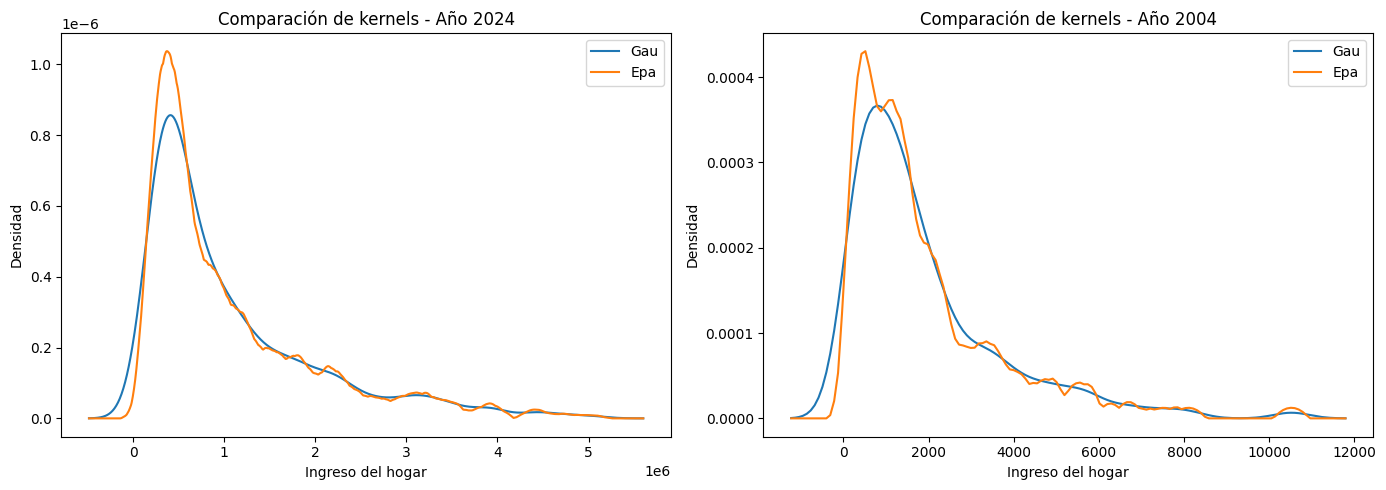

In [77]:
#3)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, year in enumerate([2024, 2004]):
    for kernel in ['gau', 'epa']:
        data = hogares_filtrados[
            (hogares_filtrados['ANO4'] == year) & 
            (hogares_filtrados['desocupado'] == 0)
        ]['ingreso_xhogar']
        data = data[data < data.quantile(0.99)]

        kde = KDEUnivariate(data)
        kde.fit(kernel=kernel, bw='silverman', fft=False)  # <- ⚠️ CORREGIDO
        axes[i].plot(kde.support, kde.density, label=kernel.capitalize())

    axes[i].set_title(f"Comparación de kernels - Año {year}")
    axes[i].set_xlabel("Ingreso del hogar")
    axes[i].set_ylabel("Densidad")
    axes[i].legend()

plt.tight_layout()
plt.show()

In [79]:
# FALTA COMPARAR LAS ESTIMACIONES Y COMENTAR DIFERENCIAS  